In [2]:
import igraph as ig
import matplotlib.pyplot as plt
import math
import numpy as np
import time
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dataset loading

In [4]:
# Load data; adj includes self-edges
edges, adj, features, labels, idx_train, idx_val, idx_test = utils.load_data()

Loading cora dataset...


### Setting up the model

In [5]:
class GraphAttentionLayer(nn.Module):
    """
    Implementation from: https://github.com/ebrahimpichka/GAT-pt/blob/main/layers.py
    
    Graph Attention Layer (GAT) as described in the paper `"Graph Attention Networks" <https://arxiv.org/pdf/1710.10903.pdf>`.

    This operation can be mathematically described as:

        e_ij = a(W h_i, W h_j)
        α_ij = softmax_j(e_ij) = exp(e_ij) / Σ_k(exp(e_ik))     
        h_i' = σ(Σ_j(α_ij W h_j))
        
        where h_i and h_j are the feature vectors of nodes i and j respectively, W is a learnable weight matrix,
        a is an attention mechanism that computes the attention coefficients e_ij, and σ is an activation function.

    """
    def __init__(self, in_features: int, out_features: int, n_heads: int, concat: bool = False, dropout: float = 0.4, leaky_relu_slope: float = 0.2):
        super(GraphAttentionLayer, self).__init__()

        self.n_heads = n_heads # Number of attention heads
        self.concat = concat # wether to concatenate the final attention heads

        if concat: # concatenating the attention heads
            self.out_features = out_features # Number of output features per node
            assert out_features % n_heads == 0 # Ensure that out_features is a multiple of n_heads
            self.n_hidden = out_features // n_heads # After concatenating, output will be of size out_features
        else: # averaging output over the attention heads (Used in the main paper)
            self.n_hidden = out_features

        #  A shared linear transformation, parametrized by a weight matrix W is applied to every node
        #  Initialize the weight matrix W 
        self.W = nn.Parameter(torch.empty(size=(in_features, self.n_hidden * n_heads)))

        # Initialize the attention weights a
        self.a = nn.Parameter(torch.empty(size=(n_heads, 2 * self.n_hidden, 1)))

        self.leakyrelu = nn.LeakyReLU(leaky_relu_slope) # LeakyReLU activation function
        self.softmax = nn.Softmax(dim=1) # softmax activation function to the attention coefficients
        self.dropout1 = nn.Dropout(p=dropout)
        self.dropout2 = nn.Dropout(p=dropout)
        
        self.reset_parameters() # Reset the parameters

    def reset_parameters(self):
        """
        Reinitialize learnable parameters.
        """
        nn.init.xavier_normal_(self.W)
        nn.init.xavier_normal_(self.a)
    

    def _get_attention_scores(self, h_transformed: torch.Tensor):
        """calculates the attention scores e_ij for all pairs of nodes (i, j) in the graph
        in vectorized parallel form. for each pair of source and target nodes (i, j),
        the attention score e_ij is computed as follows:

            e_ij = LeakyReLU(a^T [Wh_i || Wh_j]) 

            where || denotes the concatenation operation, and a and W are the learnable parameters. 

        Args:
            h_transformed (torch.Tensor): Transformed feature matrix with shape (n_heads, n_nodes, n_hidden),
                where n_nodes is the number of nodes and out_features is the number of output features per node.

        Returns:
            torch.Tensor: Attention score matrix with shape (n_heads, n_nodes, n_nodes), where n_nodes is the number of nodes.
        """
        # a has shape (n_heads, 2*n_hidden, 1)
        source_scores = torch.einsum('hni,hio->hno', h_transformed, self.a[:, :self.n_hidden, :])
        target_scores = torch.einsum('hni,hio->hno', h_transformed, self.a[:, self.n_hidden:, :])
        # broadcast add 
        # (n_heads, n_nodes, 1) + (n_heads, 1, n_nodes) = (n_heads, n_nodes, n_nodes)
        e = source_scores + target_scores.mT
        return self.leakyrelu(e)

    def forward(self,  h: torch.Tensor, adj_mat: torch.Tensor):
        """
        Performs a graph attention layer operation.

        Args:
            h (torch.Tensor): Input tensor representing node features with shape (n_nodes, in_features),
            adj_mat (torch.Tensor): Adjacency matrix representing graph structure.

        Returns:
            torch.Tensor: Output tensor after the graph convolution operation.
        """
        n_nodes = h.shape[0] 

        # Apply linear transformation to node feature -> W h
        # output shape (n_nodes, out_features * n_heads)
        h_transformed = torch.mm(h, self.W) # multiplies over in_features dimension
        # h_transformed = self.dropout1(h_transformed)

        # splitting the heads by reshaping the tensor and putting heads dim first
        # output shape (n_heads, n_nodes, n_hidden)
        h_transformed = h_transformed.view(n_nodes, self.n_heads, self.n_hidden).permute(1, 0, 2)
        
        # getting the attention scores
        # output shape (n_heads, n_nodes, n_nodes)
        e = self._get_attention_scores(h_transformed)

        # Set the attention score for non-existent edges to -9e15 (MASKING NON-EXISTENT EDGES)
        connectivity_mask = -9e16 * torch.ones_like(e)
        e = torch.where(adj_mat.to_dense() > 0, e, connectivity_mask) # masked attention scores
        
        # attention coefficients are computed as a softmax over the rows
        # for each column j in the attention score matrix e
        attention = F.softmax(e, dim=-1)
        attention = self.dropout2(attention)

        # final node embeddings are computed as a weighted average of the features of its neighbors
        h_prime = torch.matmul(attention, h_transformed)

        # concatenating/averaging the attention heads
        # output shape (n_nodes, out_features)
        if self.concat:
            h_prime = h_prime.permute(1, 0, 2).contiguous().view(n_nodes, self.out_features)
        else:
            h_prime = h_prime.mean(dim=0)

        return h_prime

In [6]:
class GAT(nn.Module):
    def __init__(self, in_features, n_hidden, n_heads, num_classes, concat=False, dropout=0.4, leaky_relu_slope=0.2):
        """ Initializes the GAT model. 

        Args:
            in_features (int): number of input features per node.
            n_hidden (int): output size of the first Graph Attention Layer.
            n_heads (int): number of attention heads in the first Graph Attention Layer.
            num_classes (int): number of classes to predict for each node.
            concat (bool, optional): Wether to concatinate attention heads or take an average over them for the
                output of the first Graph Attention Layer. Defaults to False.
            dropout (float, optional): dropout rate. Defaults to 0.4.
            leaky_relu_slope (float, optional): alpha (slope) of the leaky relu activation. Defaults to 0.2.
        """
        
        super(GAT, self).__init__()

        # Define the Graph Attention layers
        self.gat1 = GraphAttentionLayer(
            in_features=in_features, out_features=n_hidden, n_heads=n_heads,
            concat=concat, dropout=dropout, leaky_relu_slope=leaky_relu_slope
            )
        
        self.gat2 = GraphAttentionLayer(
            in_features=n_hidden, out_features=num_classes, n_heads=1,
            concat=False, dropout=dropout, leaky_relu_slope=leaky_relu_slope
            )

    def forward(self, x, adj):
        # a two-layer GCN with a ReLU activation function and dropout and softmax
        x = self.gat1(x, adj)
        x = F.relu(x) # Apply ELU activation function to the output of the first layer
        x = self.gat2(x, adj)
        return F.log_softmax(x, dim=1)


### The train loop

In [9]:
# Model and optimizer
hidden_dim = 64
num_heads = 8
concat_heads = True
fastmode = False
dropout = 0.5
lr = 0.005
weight_decay = 5e-4
use_cuda = False
epochs = 500

model = GAT(in_features=features.shape[1], n_hidden=hidden_dim, n_heads=num_heads, num_classes=labels.max().item() + 1, concat=concat_heads, dropout=dropout, leaky_relu_slope=0.2)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

if use_cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()

In [10]:
def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = utils.accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    if not fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run.
        model.eval()
        output = model(features, adj)

    # uses the nll_loss which takes the loglikelihood of the output at its true class
    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = utils.accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))

# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))


Epoch: 0001 loss_train: 1.9451 acc_train: 0.1357 loss_val: 1.9407 acc_val: 0.4700 time: 1.8885s
Epoch: 0002 loss_train: 1.9392 acc_train: 0.4500 loss_val: 1.9355 acc_val: 0.5033 time: 1.2121s
Epoch: 0003 loss_train: 1.9329 acc_train: 0.4429 loss_val: 1.9294 acc_val: 0.5000 time: 1.1390s
Epoch: 0004 loss_train: 1.9268 acc_train: 0.4929 loss_val: 1.9224 acc_val: 0.4833 time: 1.4301s
Epoch: 0005 loss_train: 1.9167 acc_train: 0.5071 loss_val: 1.9146 acc_val: 0.4833 time: 1.1565s
Epoch: 0006 loss_train: 1.9094 acc_train: 0.4857 loss_val: 1.9061 acc_val: 0.4867 time: 1.3354s
Epoch: 0007 loss_train: 1.9002 acc_train: 0.5286 loss_val: 1.8970 acc_val: 0.4967 time: 1.2541s
Epoch: 0008 loss_train: 1.8845 acc_train: 0.4929 loss_val: 1.8873 acc_val: 0.4933 time: 1.4285s
Epoch: 0009 loss_train: 1.8736 acc_train: 0.5000 loss_val: 1.8769 acc_val: 0.5000 time: 1.1557s
Epoch: 0010 loss_train: 1.8569 acc_train: 0.5143 loss_val: 1.8660 acc_val: 0.4933 time: 1.9979s
Epoch: 0011 loss_train: 1.8512 acc_train

### Present the results

In [11]:
def test():
    # add a hook to extract hidden layer output 
    activations = []
    def hook_fn(module, input, output):
        activations.append(output)
    h = model.gat1.register_forward_hook(hook_fn)
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = utils.accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))
    h.remove()
    return output, activations

# Testing
output, activations = test()
# activations is of shape [2708, 16]


Test set results: loss= 0.6221 accuracy= 0.8290


In [44]:
# Let's print a few predictions 
print(output[:10].argmax(dim=1))

tensor([1, 0, 6, 6, 4, 4, 2, 1, 1, 2])


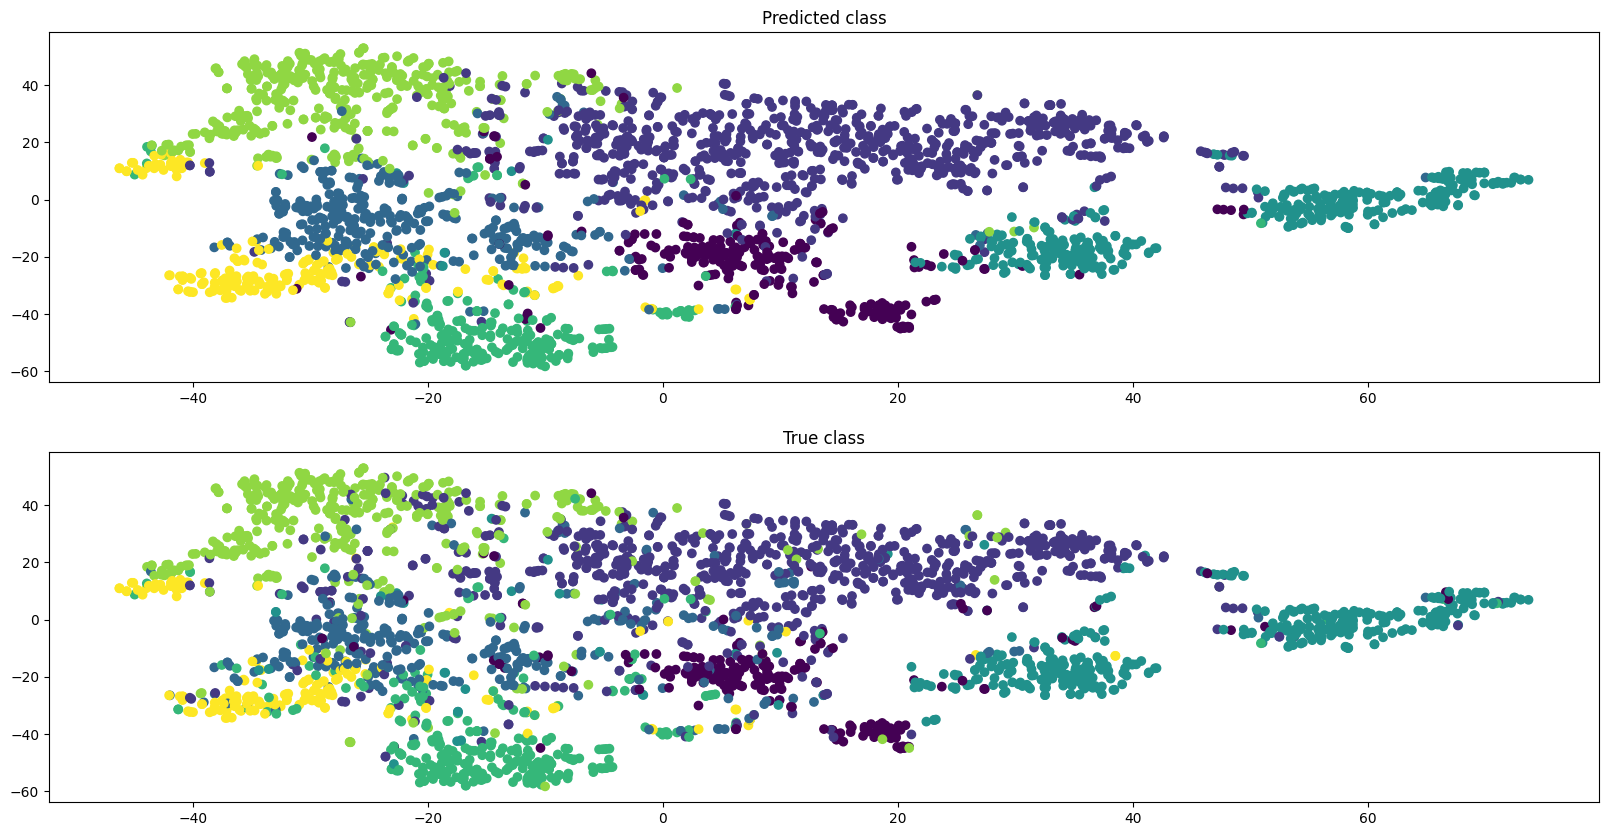

In [12]:
# plot the tsne embeddings of the hidden state activations colored by the predicted class
from sklearn.manifold import TSNE
import numpy as np

activations_np = activations[0].detach().cpu().numpy()
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(activations_np)
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].scatter(tsne_result[:,0], tsne_result[:,1], c=output.argmax(dim=1).detach().cpu().numpy())
ax[0].set_title('Predicted class')
ax[1].scatter(tsne_result[:,0], tsne_result[:,1], c=labels.cpu().numpy())
ax[1].set_title('True class')
plt.show()